# Decision Tree from Scratch

In [92]:
%reload_ext autoreload
%autoreload 2
from typing import List, Set, Tuple, Dict, Any
import sys
import os
import pandas as pd

In [3]:
! mv /home/pmolnar/decision-tree-example-data.xlsx /data/IFI8410/


In [4]:
df = pd.read_excel('/data/IFI8410/decision-tree-example-data.xlsx', sheet_name='Data')
display(df)

,ID,AGE,EDUCATION,MARITAL STATUS,OCCUPATION,ANNUAL INCOME
0,1,39,bachelors,never married,transport,25K-50K
1,2,50,bachelors,married,professional,25K-50K
2,3,18,high school,never married,agriculture,<25K
3,4,28,bachelors,married,professional,25K-50K
4,5,37,high school,married,agriculture,25K-50K
5,6,24,high school,never married,armed forces,<25K
6,7,52,high school,divorced,transport,25K-50K
7,8,40,doctorate,married,professional,>50K


# Metrics

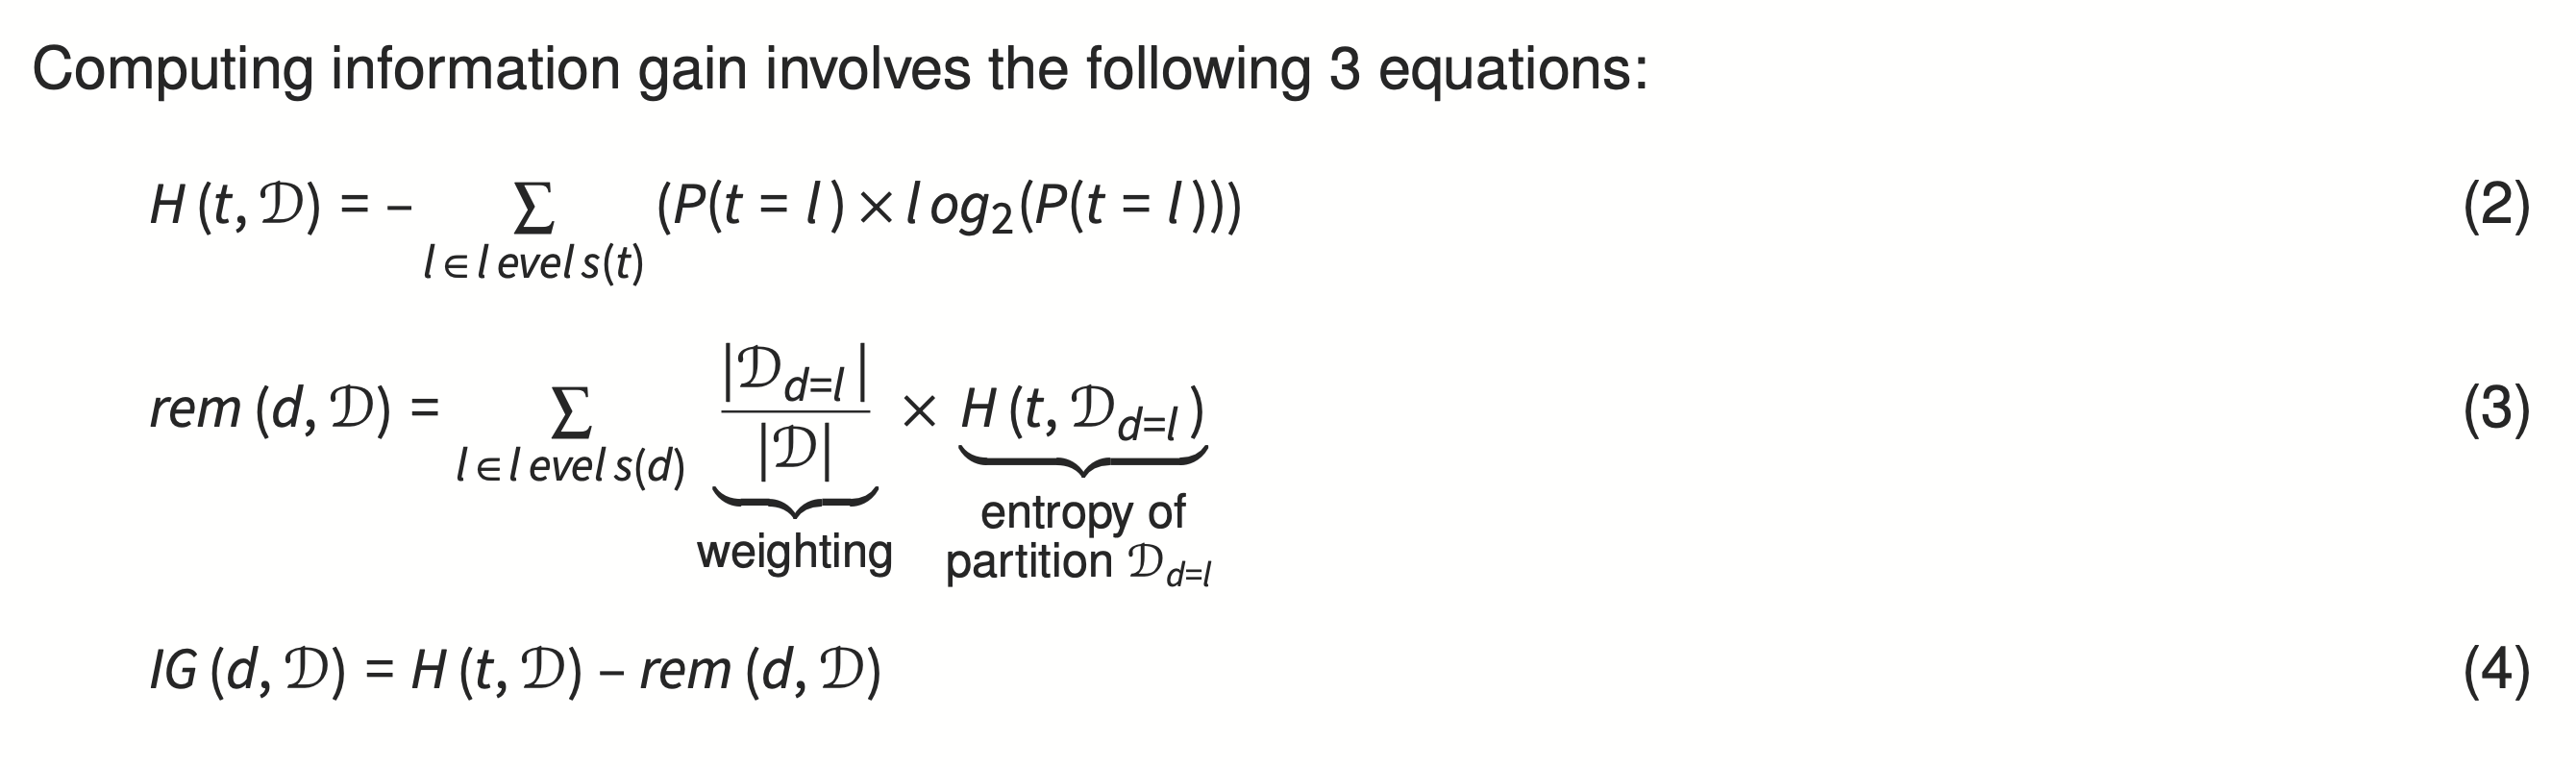

In [48]:
def H(data: pd.DataFrame, target: str) -> float:
    from numpy import log2
    num_rec = data.shape[0]
    probs = data.groupby(target)[target].count() / num_rec
    return - np.sum(probs * np.log2(probs))

In [49]:
import numpy as np
target = 'ANNUAL INCOME'
print(f"H({target}) = {H(df, target)}")

H(ANNUAL INCOME) = 1.2987949406953985


In [19]:
H(df[df['OCCUPATION'] == '>transport'], 'ANNUAL INCOME')

-1.0

In [56]:
def rem(data: pd.DataFrame, target: str, feature: str) -> float:
    n_rec = data.shape[0]
    return data.groupby(feature).apply(lambda part: part.shape[0]/n_rec * H(part, target)).sum()

In [57]:
def IG(data: pd.DataFrame, target: str, feature: str) -> float:
    return H(data, target) - rem(data, target, feature)

In [58]:
df.columns

Index(['ID', 'AGE', 'EDUCATION', 'MARITAL STATUS', 'OCCUPATION',
       'ANNUAL INCOME'],
      dtype='object')

In [70]:
# descriptives = ['AGE', 'EDUCATION', 'MARITAL STATUS', 'OCCUPATION']
descriptives = ['EDUCATION', 'MARITAL STATUS', 'OCCUPATION']
target = target = 'ANNUAL INCOME'

for desc in descriptives:
    print(f"{desc:15s}: {IG(df, target, desc):.3f}")

EDUCATION      : 0.799
MARITAL STATUS : 0.549
OCCUPATION     : 0.704


## The ID3 Algorithm
- ID3 Algorithm (Iterative Dichotomizer 3)
- Attempts to create the shallowest tree that is consistent with the data that it is given.
- The ID3 algorithm builds the tree in a recursive, depth-first manner, beginning at the root node and working down to the leaf nodes.

*Algorithm:*

1. The algorithm begins by choosing the best descriptive feature to test (i.e., the best question to ask first) using information gain.
2. A root node is then added to the tree and labelled with the selected test feature.
3. The training dataset is then partitioned using the test.
4. For each partition a branch is grown from the node.
5. The process is then repeated for each of these branches using the relevant partition of the training set in place of the full training set and with the selected test feature excluded from further testing.

*Stopping Conditions:*

The algorithm defines three situations where the recursion stops and a leaf node is constructed:
1. All of the instances in the dataset have the same classification (target feature value) then return a leaf node tree with that classification as its label.
2. The set of features left to test is empty then return a leaf node tree with the majority class of the dataset as its classification.
3. The dataset is empty return a leaf node tree with the majority class of the dataset at the parent node that made the recursive call.


In [118]:
descriptives = ['EDUCATION', 'MARITAL STATUS', 'OCCUPATION']
target = target = 'ANNUAL INCOME'

In [72]:
best_desc = descriptives[
    np.argmax([ IG(df, target, desc) for desc in descriptives ])
]
best_desc

'EDUCATION'

In [76]:
def split_dataset(data: pd.DataFrame, desc: str) -> List[Tuple[str, pd.DataFrame]]:
    dfs = []
    for lev in data[desc].drop_duplicates():
        dfs.append((lev, data[data[desc]==lev]))
    return dfs
                
    

In [137]:
def my_id3(data: pd.DataFrame, target: str, descriptives: Set[str], plane=0, path='root') -> Any:
    h = H(data, target)
    if h > 0.0 and descriptives:
        best_desc = descriptives[ np.argmax([ IG(df, target, desc) for desc in descriptives ])]
        print(f"Plane: {plane}, Desc. Feature: {best_desc}")
        sub_descriptives = descriptives.copy()
        sub_descriptives.remove(best_desc)
        dsets = split_dataset(data, best_desc)
        for ds in dsets:
            new_path = f"{path}/{best_desc}={ds[0]}"
            # print(new_path)
            my_id3(ds[1], target, sub_descriptives, plane=plane+1, path=new_path)
    else:
        # print(f"Plane: {plane}, Done.")
        print(f"\n{path}\n---------------------------------")
        #print(data.to_json(orient='records'))
        print(data.to_csv(index=None))
        # return {'Data': data.to_dict(orient='records')}

In [117]:
descriptives

[]

In [138]:
my_id3(df, target, descriptives)

Plane: 0, Desc. Feature: EDUCATION

root/EDUCATION=bachelors
---------------------------------
ID,AGE,EDUCATION,MARITAL STATUS,OCCUPATION,ANNUAL INCOME
1,39,bachelors,never married,transport,25K-50K
2,50,bachelors,married,professional,25K-50K
4,28,bachelors,married,professional,25K-50K

Plane: 1, Desc. Feature: OCCUPATION
Plane: 2, Desc. Feature: MARITAL STATUS

root/EDUCATION=high school/OCCUPATION=agriculture/MARITAL STATUS=never married
---------------------------------
ID,AGE,EDUCATION,MARITAL STATUS,OCCUPATION,ANNUAL INCOME
3,18,high school,never married,agriculture,<25K


root/EDUCATION=high school/OCCUPATION=agriculture/MARITAL STATUS=married
---------------------------------
ID,AGE,EDUCATION,MARITAL STATUS,OCCUPATION,ANNUAL INCOME
5,37,high school,married,agriculture,25K-50K


root/EDUCATION=high school/OCCUPATION=armed forces
---------------------------------
ID,AGE,EDUCATION,MARITAL STATUS,OCCUPATION,ANNUAL INCOME
6,24,high school,never married,armed forces,<25K


root/EDUCAT

In [78]:
data_sets = split_dataset(df, 'EDUCATION')
data_sets

[('bachelors',
     ID  AGE  EDUCATION MARITAL STATUS    OCCUPATION ANNUAL INCOME
  0   1   39  bachelors  never married     transport       25K-50K
  1   2   50  bachelors        married  professional       25K-50K
  3   4   28  bachelors        married  professional       25K-50K),
 ('high school',
     ID  AGE    EDUCATION MARITAL STATUS    OCCUPATION ANNUAL INCOME
  2   3   18  high school  never married   agriculture          <25K
  4   5   37  high school        married   agriculture       25K-50K
  5   6   24  high school  never married  armed forces          <25K
  6   7   52  high school       divorced     transport       25K-50K),
 ('doctorate',
     ID  AGE  EDUCATION MARITAL STATUS    OCCUPATION ANNUAL INCOME
  7   8   40  doctorate        married  professional          >50K)]

In [46]:

for lev in df['EDUCATION'].drop_duplicates():
    part = df[df['EDUCATION'] == lev].copy()
    n_part = part.shape[0]
    H_part = H(part, target)
    print(lev, n_part, H_part) 
            
    

bachelors 3 1.2987949406953985
high school 4 1.2987949406953985
doctorate 1 1.2987949406953985


In [ ]:
{'Feature': 'EDUCATION'

In [91]:
{ ds[0]: ds[1].to_dict(orient='records') for ds in data_sets }

{'bachelors': [{'ID': 1,
   'AGE': 39,
   'EDUCATION': 'bachelors',
   'MARITAL STATUS': 'never married',
   'OCCUPATION': 'transport',
   'ANNUAL INCOME': '25K-50K'},
  {'ID': 2,
   'AGE': 50,
   'EDUCATION': 'bachelors',
   'MARITAL STATUS': 'married',
   'OCCUPATION': 'professional',
   'ANNUAL INCOME': '25K-50K'},
  {'ID': 4,
   'AGE': 28,
   'EDUCATION': 'bachelors',
   'MARITAL STATUS': 'married',
   'OCCUPATION': 'professional',
   'ANNUAL INCOME': '25K-50K'}],
 'high school': [{'ID': 3,
   'AGE': 18,
   'EDUCATION': 'high school',
   'MARITAL STATUS': 'never married',
   'OCCUPATION': 'agriculture',
   'ANNUAL INCOME': '<25K'},
  {'ID': 5,
   'AGE': 37,
   'EDUCATION': 'high school',
   'MARITAL STATUS': 'married',
   'OCCUPATION': 'agriculture',
   'ANNUAL INCOME': '25K-50K'},
  {'ID': 6,
   'AGE': 24,
   'EDUCATION': 'high school',
   'MARITAL STATUS': 'never married',
   'OCCUPATION': 'armed forces',
   'ANNUAL INCOME': '<25K'},
  {'ID': 7,
   'AGE': 52,
   'EDUCATION': 'hig